In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import utils
import matplotlib.pyplot as plt
import numpy as np

datafile = 'preprocessed_data.csv'

window_size = 2
start = 2010
end = 2019
end_train = end - (window_size)*2
start_test = end_train + window_size
end_test = start_test

train_X, train_y, X_mean, X_std, y_mean, y_std, _ = utils.get_data(start, end_train, datafile)
test_X, test_y, _, _, _, _, _ = utils.get_data(start_test, end_test, datafile)

train_X = ( train_X - X_mean ) / X_std
test_X = ( test_X - X_mean ) / X_std

train_y = ( train_y - y_mean ) / y_std 
test_y = ( test_y - y_mean ) / y_std


MSE: 17565775.018819544
[[  232   279   321   495   725  1386  2004  3292  3603  4650  6935 11898
  16568 14643 13457 15126 17630 20940 20960 19897 17932 15615 13974 11397
   5268   997   299   112    82    24    23    20    15    14     4    20
     12    18    14    11    11    16     6     8    10     4    12    10
     11     8    28    16]]


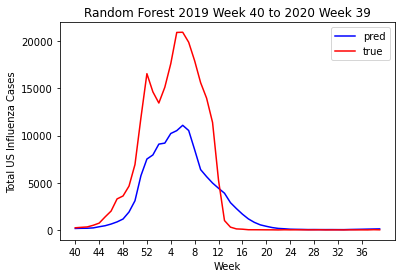

In [27]:
#rf = RandomForestRegressor(n_estimators=300, bootstrap=False)
rf = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1,
                            max_features='sqrt', max_depth=50, bootstrap=False)
rf.fit(train_X, train_y)
pred_y = rf.predict(test_X)

pred_y = pred_y * y_std + y_mean # de-norm
test_y = test_y * y_std + y_mean

weeks = [i for i in range(52)]
#plt.rcParams['font.size'] = '12'
print(f"MSE: {mean_squared_error(pred_y, test_y)}")
# compare test_y and pred_y
plt.plot(weeks, pred_y[0], label="pred", color="blue")
plt.plot(weeks, test_y[0], label="true", color="red")
plt.title(f"Random Forest {end} Week 40 to {end+1} Week 39")
plt.xlabel("Week")
plt.ylabel("Total US Influenza Cases")
plt.legend()

week_labels = [i%52 + 1 for i in range(39, 52+39, 4)]
_, _ = plt.xticks(weeks[::4], week_labels)

import pickle
pickle.dump(pred_y[0], open("results/RF_2019_pred_list", "wb"), 2)

print(test_y.astype(int))

In [3]:
# randomized search below

from pprint import pprint
rf = RandomForestRegressor()
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [28]:
'''
How do we know where to start? A good place is the documentation on the random forest in Scikit-Learn.
This tells us the most important settings are the number of trees in the forest (n_estimators) and the
number of features considered for splitting at each leaf node (max_features).
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 
n_estimators = number of trees in the foreset
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
bootstrap = method for sampling data points (with or without replacement)
'''
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [29]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100,
                            cv = 3, verbose=2, random_state=42, n_jobs = -1,
                            scoring = 'neg_mean_squared_error')
# Fit the random search model
rf_random.fit(train_X, train_y)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f}.'.format(errors))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_X, train_y)
base_error = evaluate(base_model, test_X, test_y)

best_random = rf_random.best_estimator_
random_error = evaluate(best_random, test_X, test_y)

print('Improvement of {:0.2f}%.'.format( 100 * (random_error - base_error) / base_error))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model Performance


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [ ]:
results = rf_random.cv_results_
n_top = 5
for i in range(1, n_top + 1):
    candidates = np.flatnonzero(results['rank_test_score'] == i)
    for candidate in candidates:
        print("Model with rank: {0}".format(i))
        print("Mean validation score: {0:.3f} (std: {1:.3f})"
                .format(results['mean_test_score'][candidate],
                        results['std_test_score'][candidate]))
        print("Parameters: {0}".format(results['params'][candidate]))
        print("")

Model with rank: 1
Mean validation score: -0.774 (std: 0.554)
Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}

Model with rank: 2
Mean validation score: -0.784 (std: 0.540)
Parameters: {'n_estimators': 1366, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}

Model with rank: 3
Mean validation score: -0.790 (std: 0.534)
Parameters: {'n_estimators': 944, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': True}

Model with rank: 4
Mean validation score: -0.793 (std: 0.531)
Parameters: {'n_estimators': 944, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

Model with rank: 5
Mean validation score: -0.807 (std: 0.508)
Parameters: {'n_estimators': 311, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 3